<a href="https://colab.research.google.com/github/anna01122002/GalaxyRecognition/blob/main/detection_galaxy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GALAXY RECOGNITION

In [ ]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from importlib import reload
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import glob
from shutil import copyfile
from keras.models import load_model
from keras import optimizers
from sklearn.metrics import f1_score, recall_score, precision_score, average_precision_score

# ResNet50

In [ ]:
img_shape = (224, 224, 3)

resnet_model = ResNet50(include_top=False, input_shape=img_shape)

**Настройка**

In [ ]:
def append_ext(filename):
    return filename + ".jpg"

classes = [
    'P_EL', 'P_CW', 'P_ACW', 'P_EDGE', 'P_DK', 'P_MG', 'P_CS', 'P_EL_DEBIASED', 
    'P_CS_DEBIASED'
]

path_directory = '/content/drive/MyDrive/galaxy_recognition/img'
path_csv = '/content/drive/MyDrive/galaxy_recognition/galaxy_recognition.csv'
train_df = pd.read_csv(path_csv)
train_df.head(20)

,OBJ_ID,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED
0,587727178986356823,0.610,0.034,0.000,0.153,0.153,0.051,0.186,0.610,0.186
1,587727227300741210,0.611,0.000,0.167,0.222,0.000,0.000,0.389,0.203,0.797
2,587727225153257596,0.735,0.029,0.000,0.147,0.074,0.015,0.176,0.432,0.428
3,587730774962536596,0.885,0.019,0.000,0.058,0.019,0.019,0.077,0.885,0.077
4,587731186203885750,0.712,0.000,0.000,0.220,0.068,0.000,0.220,0.640,0.290
5,587727180060098638,0.857,0.000,0.036,0.000,0.107,0.000,0.036,0.830,0.060
6,587731187277627676,0.500,0.000,0.053,0.289,0.105,0.053,0.342,0.351,0.473
7,587727223024189605,0.423,0.000,0.000,0.577,0.000,0.000,0.577,0.143,0.857
8,587730775499407375,0.355,0.016,0.210,0.323,0.000,0.097,0.548,0.355,0.548
9,587727221950382424,0.484,0.129,0.065,0.258,0.065,0.000,0.452,0.109,0.789


In [ ]:
train_df["id"] = train_df['OBJ_ID'].astype(str).apply(append_ext)
train_df["id"].head()

0    587727178986356823.jpg
1    587727227300741210.jpg
2    587727225153257596.jpg
3    587730774962536596.jpg
4    587731186203885750.jpg
Name: id, dtype: object

**Генерация тестовой и валидационной выборки**

In [ ]:
datagen = ImageDataGenerator(
    fill_mode='nearest',
    cval=0,
    rescale=1. / 255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.02)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_directory,
    x_col="id",
    y_col=classes,
    subset="training",
    batch_size=64,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_directory,
    x_col="id",
    y_col=classes,
    subset="validation",
    batch_size=64,
    seed=123,
    shuffle=True,
    class_mode="other",
    target_size=(224, 224))

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 21849 validated image filenames.
Found 445 validated image filenames.


In [ ]:
# Сгладить вывод последнего слоя перед добавлением выходного слоя
x = Flatten()(resnet_model.output)

# Добавить выходной слой (количество выходов = 37)
x = Dense(len(classes), activation='sigmoid')(x)

# Загрузка измененной модели
model = Model(inputs=resnet_model.input, outputs=x)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
path_weights = '/content/drive/MyDrive/galaxy_recognition/today_15_epochs/weights.hdf5'
path_model = '/content/drive/MyDrive/galaxy_recognition/detection_galaxy.h5'
path_logs = '/content/drive/MyDrive/galaxy_recognition/logs.csv'

**Генерация тестовой подборки**

In [ ]:
path_test_csv = '/content/drive/MyDrive/galaxy_recognition/pred/test_galaxy.csv'
test_df = pd.read_csv(path_test_csv)
test_df.head(20)

,OBJID,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED
0,587737826743419292,0.442,0.000,0.000,0.000,0.058,0.500,0.000,0.442,0.000
1,587738067799507405,0.824,0.029,0.000,0.059,0.088,0.000,0.088,0.493,0.324
2,587738067262046430,0.500,0.000,0.100,0.350,0.050,0.000,0.450,0.234,0.701
3,587738066724847913,0.391,0.000,0.000,0.043,0.565,0.000,0.043,0.308,0.066
4,587737826743419128,0.333,0.000,0.000,0.037,0.185,0.444,0.037,0.333,0.038
5,587738067799441789,0.684,0.000,0.053,0.053,0.053,0.158,0.105,0.542,0.206
6,587738067262243099,0.673,0.055,0.000,0.255,0.000,0.018,0.309,0.624,0.357
7,587738067262177666,0.853,0.000,0.029,0.088,0.029,0.000,0.118,0.609,0.345
8,587738067262177654,0.560,0.000,0.040,0.400,0.000,0.000,0.440,0.560,0.440
9,587737827280683484,0.690,0.000,0.103,0.207,0.000,0.000,0.310,0.400,0.600


In [ ]:
test_df["id"] = test_df['OBJID'].astype(str).apply(append_ext)
test_df["id"].head()

0    587737826743419292.jpg
1    587738067799507405.jpg
2    587738067262046430.jpg
3    587738066724847913.jpg
4    587737826743419128.jpg
Name: id, dtype: object

In [ ]:
path_test_img = '/content/drive/MyDrive/galaxy_recognition/pred/images'
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_test_img,
    x_col="id",
    y_col=classes,
    color_mode = "rgb",
    batch_size=1,
    seed=123,
    shuffle=False,
    class_mode="other",
    target_size=(224, 224))

Found 2000 validated image filenames.


# Обучение модели

Обучение модели проводилось на удаленном ПК в IDE PyCharm.

NVIDIA GeForce RTX 3070 TI

Intel Core i7-12700K

ОЗУ - 32ГБ (DDR5)

In [ ]:
for layer in model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=5e-4)
model.compile(optimizer, loss='mse', metrics=["accuracy"])

In [ ]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))


early_stopping = EarlyStopping(
    monitor='val_loss', patience=4, verbose=1, mode='auto')

history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='today_15_epochs/weights.hdf5', verbose=2, save_best_only=True)

**Сохранение истории обучения**

In [ ]:
# The model was trained on a remote PC in pycharm
csv_logger = tf.keras.callbacks.CSVLogger('logs.csv', separator=',', append=False)

**Обучение**

In [ ]:
# The model was trained on a remote PC in pycharm
hist = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=15,
    callbacks=[history, checkpointer, early_stopping, csv_logger])

**Сохранение модели**

In [ ]:
# The model was trained on a remote PC in pycharm
model.save('galaxy_detection')
model.save('galaxy.h5')

# Работа с ранее обученной моделью

In [ ]:
result_model = load_model(path_model)
#optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=5e-4)
#result_model = load_model(path_weights)
#result_model.compile(optimizer, loss='mse', metrics=["accuracy"])

In [ ]:
result_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# history
history_train = pd.read_csv(path_logs)
history_train

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.747533,0.034735,0.562500,0.058927
1,1,0.785082,0.027211,0.559896,0.134170
2,2,0.794767,0.025158,0.546875,0.051781
3,3,0.808263,0.021456,0.786458,0.024694
4,4,0.814873,0.020943,0.796875,0.019589
5,5,0.809823,0.020674,0.791667,0.020687
6,6,0.815653,0.019830,0.833333,0.017135
7,7,0.812118,0.019361,0.828125,0.017515
8,8,0.809135,0.021106,0.747396,0.034904
9,9,0.815561,0.019235,0.760417,0.021220


**Предсказания**

In [ ]:
test_generator.reset()
predictions = result_model.predict(
    test_generator,
    steps=test_generator.n / test_generator.batch_size,
    verbose=1)

print(predictions.shape)

2000/2000 [==============================] - 423s 211ms/step
(2000, 9)


In [ ]:
predictions

array([[0.8011736 , 0.01416246, 0.01580282, ..., 0.09002407, 0.71195185,
        0.16918305],
       [0.805067  , 0.01475621, 0.01768764, ..., 0.08105935, 0.7177781 ,
        0.15253408],
       [0.4902183 , 0.0645097 , 0.08172103, ..., 0.35733256, 0.26792535,
        0.5561189 ],
       ...,
       [0.7112001 , 0.03082732, 0.03454107, ..., 0.13818781, 0.55912846,
        0.23826803],
       [0.74535006, 0.01709834, 0.01894934, ..., 0.13822107, 0.60666525,
        0.26311317],
       [0.19650154, 0.2394169 , 0.2540023 , ..., 0.75581276, 0.0627133 ,
        0.87204605]], dtype=float32)

In [ ]:
p_pred = predictions.flatten()
y_pred = np.where(p_pred > 0.4, 1, 0)

**Тестовые значения**

In [ ]:
df_test = pd.read_csv(path_test_csv)
df_test.head()

,OBJID,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED
0,587737826743419292,0.442,0.000,0.0,0.000,0.058,0.500,0.000,0.442,0.000
1,587738067799507405,0.824,0.029,0.0,0.059,0.088,0.000,0.088,0.493,0.324
2,587738067262046430,0.500,0.000,0.1,0.350,0.050,0.000,0.450,0.234,0.701
3,587738066724847913,0.391,0.000,0.0,0.043,0.565,0.000,0.043,0.308,0.066
4,587737826743419128,0.333,0.000,0.0,0.037,0.185,0.444,0.037,0.333,0.038


In [ ]:
df_test = df_test.drop(['OBJID'], axis='columns')
df_test.head()

,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED
0,0.442,0.000,0.0,0.000,0.058,0.500,0.000,0.442,0.000
1,0.824,0.029,0.0,0.059,0.088,0.000,0.088,0.493,0.324
2,0.500,0.000,0.1,0.350,0.050,0.000,0.450,0.234,0.701
3,0.391,0.000,0.0,0.043,0.565,0.000,0.043,0.308,0.066
4,0.333,0.000,0.0,0.037,0.185,0.444,0.037,0.333,0.038


In [ ]:
true_data = df_test.to_numpy(dtype=np.float32)
true_data

array([[0.442, 0.   , 0.   , ..., 0.   , 0.442, 0.   ],
       [0.824, 0.029, 0.   , ..., 0.088, 0.493, 0.324],
       [0.5  , 0.   , 0.1  , ..., 0.45 , 0.234, 0.701],
       ...,
       [0.531, 0.   , 0.031, ..., 0.219, 0.252, 0.393],
       [0.704, 0.037, 0.   , ..., 0.259, 0.627, 0.335],
       [0.226, 0.371, 0.032, ..., 0.758, 0.158, 0.826]], dtype=float32)

In [ ]:
p_true = true_data.flatten()
y_true = np.where(p_true > 0.4, 1, 0)

# Оценка

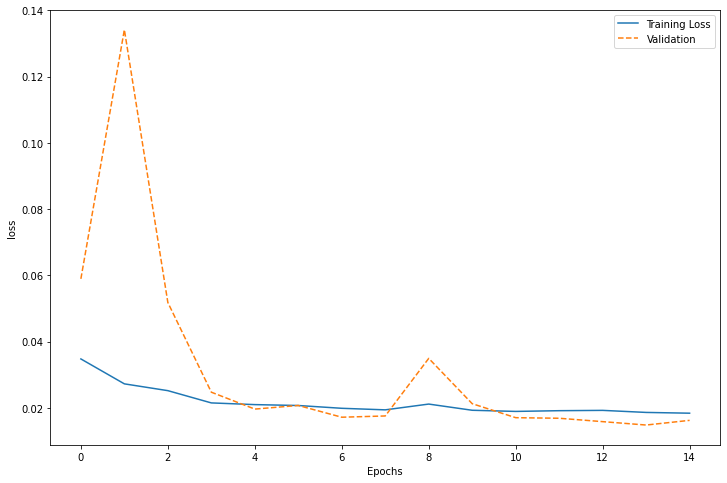

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_train['epoch'], history_train['loss'], label='Training Loss')
plt.plot(
    history_train['epoch'], history_train['val_loss'], label='Validation', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

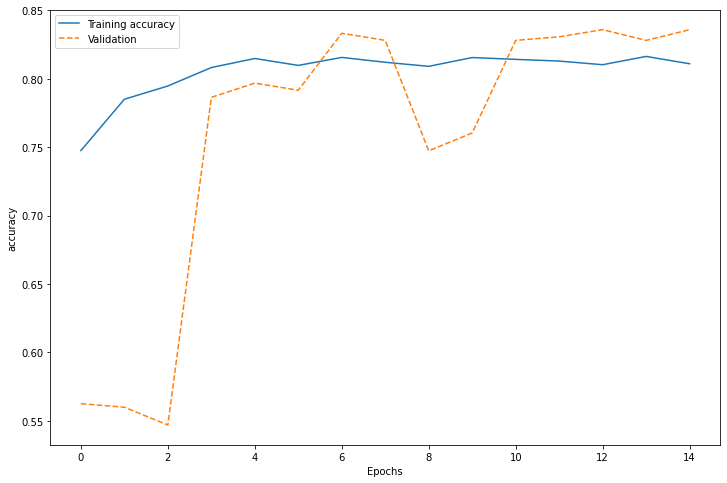

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_train['epoch'], history_train['accuracy'], label='Training accuracy')
plt.plot(
    history_train['epoch'], history_train['val_accuracy'], label='Validation', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
score = result_model.evaluate(test_generator)
print(score)

2000/2000 [==============================] - 422s 210ms/step - loss: 0.0216 - accuracy: 0.8190
[0.021629519760608673, 0.8190000057220459]


In [ ]:
f1_score(y_true, y_pred, average='weighted')

0.9150725964979204

In [ ]:
recall_score(y_true, y_pred, average='weighted')

0.9157777777777778

In [ ]:
precision_score(y_true, y_pred, average='weighted')

0.9147237471502714

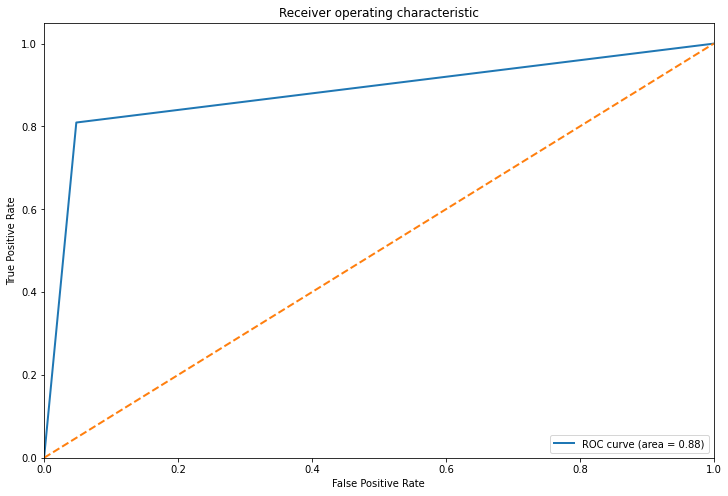

In [ ]:
from sklearn.metrics import roc_curve, auc
n_classes=9
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_true, y_pred)
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure(figsize=(12, 8))
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Результат

**Запись результатов в файл**

In [ ]:
path_header = '/content/drive/MyDrive/galaxy_recognition/all_zeros_benchmark.csv'
header = open(path_header, 'r').readlines()[0]
header

'OBJID,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED\n'

In [ ]:
def get_id(filename):
    return filename.replace(".jpg", "")

In [ ]:

with open('Output.csv', 'w') as outfile:
    outfile.write(header)
    for i in range(len(predictions)):
        identifier = (get_id(test_generator.filenames[i]))
        pred = predictions[i]
        outline = identifier + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")

In [ ]:
output = pd.read_csv('/content/Output.csv')
output.head(20)

,OBJID,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED
0,587737826743419292,0.801174,0.014162,0.015803,0.054080,0.069529,0.034258,0.090024,0.711952,0.169183
1,587738067799507405,0.805067,0.014756,0.017688,0.051589,0.084045,0.037645,0.081059,0.717778,0.152534
2,587738067262046430,0.490218,0.064510,0.081721,0.199175,0.090872,0.041938,0.357333,0.267925,0.556119
3,587738066724847913,0.793294,0.015942,0.016954,0.051065,0.093044,0.029648,0.084765,0.677704,0.168982
4,587737826743419128,0.740395,0.016177,0.022736,0.046852,0.114136,0.064820,0.084389,0.696543,0.119333
5,587738067799441789,0.704979,0.017762,0.021705,0.145635,0.056955,0.022660,0.192852,0.521847,0.366497
6,587738067262243099,0.829179,0.007579,0.009886,0.059897,0.043791,0.027547,0.084246,0.772382,0.153792
7,587738067262177666,0.827144,0.011180,0.011597,0.045275,0.064014,0.028864,0.074594,0.748019,0.144582
8,587738067262177654,0.439540,0.035466,0.028784,0.361109,0.061275,0.032883,0.416894,0.356251,0.504892
9,587737827280683484,0.835771,0.007805,0.009647,0.048967,0.046934,0.030630,0.075493,0.778113,0.140443
